## Simple ODE problem

Differential equation:
$$
\frac{du}{dt} = p u, \\
u(t=0) = u_0 = 1
$$

Solution:
$$
u(t) = \exp({p t})
$$

In [1]:
import torch
import matplotlib.pyplot as plt

from diffeqtorch import DiffEq
%matplotlib inline

# ODE specified in Julia as a string, see DifferentialEquations.jl for documentation
f = """
function f(du,u,p,t)
    du[1] = p[1] * u[1]
end
"""

# Create instance of DiffEq while enabling debugging
# Usually, we won't need debugging but it's good for getting a clue of what is going on
de = DiffEq(f, debug=1)

Initializing `DiffEq` with keywords:
    problem_type_grad: ODEForwardSensitivityProblem
    problem_type_no_grad: ODEProblem
    solver: Tsit5
    reltol: 1e-08
    abstol: 1e-08
    saveat: 0.1
    using: ['DifferentialEquations, DiffEqSensitivity']
    debug: 1

Started Julia through `PyJulia`, took 9.00sec

Julia >>>
using DifferentialEquations, DiffEqSensitivity
<<<


Julia >>>

function f(du,u,p,t)
    du[1] = p[1] * u[1]
end

<<<



When initializing `DiffEq` the different keyword arguments that can be passed are:

In [2]:
help(DiffEq.__init__)

Help on function __init__ in module diffeqtorch.diffeqtorch:

__init__(self, f: 'str', problem_type_grad: 'str' = 'ODEForwardSensitivityProblem', problem_type_no_grad: 'str' = 'ODEProblem', solver: 'str' = 'Tsit5', reltol: 'float' = 1e-08, abstol: 'float' = 1e-08, saveat: 'float' = 0.1, using: 'List[str]' = ['DifferentialEquations, DiffEqSensitivity'], pyjulia_opts: 'Dict[str, Any]' = {'compiled_modules': False, 'sysimage': '/Users/jm/.julia_sysimage_diffeqtorch.so', 'runtime': 'julia'}, debug: 'Union[bool, int]' = 0)
    Initialize solver module
    
    Args:
        f: Function definition in Julia, see [1] for details
        problem_type_grad: The DifferentialEquations.jl problem type used when
            gradients calculation is required, see [1] for details
        problem_type_no_grad: The DifferentialEquations.jl problem type used when
            no gradients calculation is required, see [1] for details
        solver: The solver that is used, see [1] for details
        relt

Next, solve the equation given initial conditions `u0`, a timespan `tspan` (start and end points), and parameters `p`:

In [3]:
u0 = torch.tensor([1.])
tspan = torch.tensor([0., 3.])
p = torch.tensor([1.01])

u, t = de(u0, tspan, p)


Julia >>>

u0 = [1.0]
tspan = (0.0, 3.0)
p = [1.0099999904632568]

prob = ODEProblem(f,u0,tspan,p)

solution = solve(prob,Tsit5(),reltol=1e-08,abstol=1e-08,saveat=0.1)

solution.u, solution.t

<<<



When calling `de(...)` as we just did, `DiffEq.forward` is invoked under the hood. The docstring for this method is:

In [4]:
help(DiffEq.forward)

Help on function forward in module diffeqtorch.diffeqtorch:

forward(self, u0: 'torch.Tensor', tspan: 'torch.Tensor', p: 'torch.Tensor') -> 'Tuple[torch.Tensor, torch.Tensor]'
    Forward pass through solver
    
    Args:
        u0: Initial values as a 1d tensor
        tspan: Start and end points for integration
        p: Parameters as a 1d tensor
    
    Returns:
        Returns solutions `u` and timesteps `t`



With that out of the way, let's plot the solution and compare it to the analytical one.

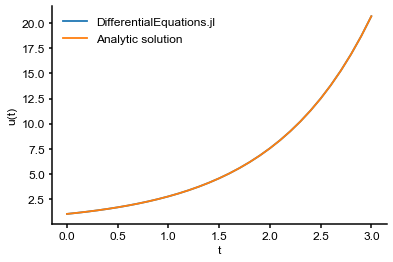

In [5]:
# Plot solution against analytic solution
u_analytic = torch.exp(p * t)

plt.plot(t, u.T, label="DifferentialEquations.jl");
plt.plot(t, u_analytic, label="Analytic solution");
plt.xlabel("t")
plt.ylabel("u(t)")
plt.legend();

## Benchmark

Due to the way julia works, the first solution is slow but subsequent calls will be much faster now (compilation happening behind the scenes). It's important to keep this in mind -- e.g., when benchmarking, do a dummy run first. We already did a run, so that's fine.

In [6]:
de.debug = False  # Disable debug output

In [7]:
%%timeit
_ = de(u0, tspan, p)

1.26 ms ± 38.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## Gradients

The analytical gradient of $u(t)$ with respect to $p$ is:

$$
\frac{du(t)}{dp} = t \exp{(p t)}
$$

We want to test whether this matches the computed gradient.

The parameter that we want to compute the derivate for:

In [8]:
p = torch.tensor([2.0], requires_grad=True)

Notice that `requires_grad=True`. Without it, we won't ask Julia to compute gradients since this introduces an overhead. By default gradients are computed using forward sensitivities, making the execution slower than before:

In [9]:
%%timeit
_ = de(u0, tspan, p)

1.88 ms ± 131 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


Once again, turn on debug output to level 3 (see docstring of `DiffEq` for an explanation) and solve:

In [10]:
de.debug = 3
u, t = de(u0, tspan, p)

p.shape: torch.Size([1])
u0.shape: torch.Size([1]))
tspan.shape: torch.Size([2])
p: tensor([2.], requires_grad=True)
u0: tensor([1.]))
tspan: tensor([0., 3.])
compute_grad_p: True

Julia >>>

u0 = [1.0]
tspan = (0.0, 3.0)
p = [2.0]

prob = ODEForwardSensitivityProblem(f,u0,tspan,p)

solution = solve(prob,Tsit5(),reltol=1e-08,abstol=1e-08,saveat=0.1)

u, du = extract_local_sensitivities(solution)

u, du, solution.t

<<<

u.shape: torch.Size([1, 31]))
du.shape: torch.Size([1, 1, 31]))
t.shape: torch.Size([31]))
u: tensor([[  1.0000,   1.2214,   1.4918,   1.8221,   2.2255,   2.7183,   3.3201,
           4.0552,   4.9530,   6.0496,   7.3891,   9.0250,  11.0232,  13.4637,
          16.4446,  20.0855,  24.5325,  29.9641,  36.5982,  44.7012,  54.5982,
          66.6863,  81.4509,  99.4843, 121.5104, 148.4132, 181.2722, 221.4064,
         270.4264, 330.2996, 403.4288]], dtype=torch.float64))
du: tensor([[[0.0000e+00, 1.2214e-01, 2.9836e-01, 5.4664e-01, 8.9022e-01,
          1.3591e+00, 1.9921e

In the Julia code from the debug, we can see that a `ODEForwardSensitivityProblem` was created.

This is the default problem when gradients wrt to p are required and can be changed when setting up `DiffEq`.

We can also see the computed solution for `du` in the output.

In [11]:
# Copied from debugging info above
du = torch.tensor([0.0000e+00, 1.2214e-01, 2.9836e-01, 5.4664e-01, 8.9022e-01, 1.3591e+00,
1.9921e+00, 2.8386e+00, 3.9624e+00, 5.4447e+00, 7.3891e+00, 9.9275e+00,
1.3228e+01, 1.7503e+01, 2.3023e+01, 3.0128e+01, 3.9252e+01, 5.0939e+01,
6.5877e+01, 8.4932e+01, 1.0920e+02, 1.4004e+02, 1.7919e+02, 2.2881e+02,
2.9163e+02, 3.7103e+02, 4.7131e+02, 5.9780e+02, 7.5719e+02, 9.5787e+02,
1.2103e+03], dtype=torch.float64)

The analytical solution is:

In [12]:
du_analytic = t * torch.exp(p * t)

Comparing both, they match very closely:

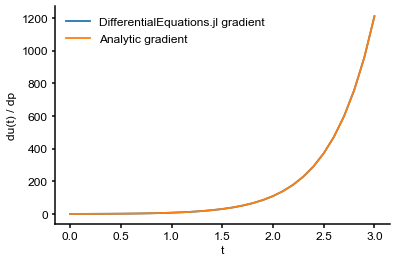

In [13]:
plt.plot(t.detach(), du, label="DifferentialEquations.jl gradient");
plt.plot(t.detach(), du_analytic.detach(), label="Analytic gradient");
plt.xlabel("t")
plt.ylabel("du(t) / dp")
plt.legend();

## Scalar loss

Above, we copied the gradient `du` from the debug info rather than reading it out in code after calling PyTorch's `backward()`.

The reason is the following: PyTorch only supports taking gradients wrt to scalar outputs. So calling `u.backward()` will yield a runtime error.

The scenario in which we will use PyTorch's autodiff is thus one where we do additional computations on `u`, i.e., use it to define a loss or likelihood function. 

For simplicity, assume that this function is simply the sum over all elements squared:

$$
L(p) = \sum_{t=1}^T u(t)^2 = \sum_{t=1}^T \exp({p t})^2 =  \sum_{t=1}^T \exp({2 p t})
$$

Therefore:
$$
\frac{dL(p)}{dp} = \sum_{t=1}^T 2t \exp{(2pt)}
$$

We can check that we obtain the correct solution by calling `backward` on `loss`:

In [14]:
loss = (u**2).sum()
loss.backward()

du.shape: torch.Size([1, 1, 31]))
grad_output_u.shape: torch.Size([1, 31]))
du: tensor([[[0.0000e+00, 1.2214e-01, 2.9836e-01, 5.4664e-01, 8.9022e-01,
          1.3591e+00, 1.9921e+00, 2.8386e+00, 3.9624e+00, 5.4447e+00,
          7.3891e+00, 9.9275e+00, 1.3228e+01, 1.7503e+01, 2.3023e+01,
          3.0128e+01, 3.9252e+01, 5.0939e+01, 6.5877e+01, 8.4932e+01,
          1.0920e+02, 1.4004e+02, 1.7919e+02, 2.2881e+02, 2.9163e+02,
          3.7103e+02, 4.7131e+02, 5.9780e+02, 7.5719e+02, 9.5787e+02,
          1.2103e+03]]], dtype=torch.float64))
grad_output_u: tensor([[  2.0000,   2.4428,   2.9836,   3.6442,   4.4511,   5.4366,   6.6402,
           8.1104,   9.9061,  12.0993,  14.7781,  18.0500,  22.0464,  26.9275,
          32.8893,  40.1711,  49.0651,  59.9282,  73.1965,  89.4024, 109.1963,
         133.3727, 162.9017, 198.9686, 243.0208, 296.8263, 362.5445, 442.8128,
         540.8528, 660.5991, 806.8576]], dtype=torch.float64))
grad_p.shape: torch.Size([1]))
grad_p: tensor([2761299.4939

In [15]:
grad_p = p.grad
grad_p_analytical = (2*t*torch.exp(2*p*t)).sum()

print(f"grad_p by auto-diff: {grad_p.item()}")
print(f"grad_p analytical: {grad_p_analytical}")

print(f"difference: {grad_p.item() - grad_p_analytical}")

grad_p by auto-diff: 2761299.5
grad_p analytical: 2761299.491053908
difference: 0.008946091867983341


If you are interested in seeing how `grad_p` is computed in the code, take a look at the backward `diffeqtorch/diffeqtorch.py`: It comes down to using the multivariate chain rule with `du` and `grad_output_u`.

## Numerical checking

See: https://pytorch.org/docs/stable/autograd.html#numerical-gradient-checking
for details.

In [16]:
from torch.autograd import gradcheck

de.debug = False

def loss_fun(p):
    u, t = de(u0, tspan, p)
    return (u**2).sum()

test = gradcheck(loss_fun, p, eps=1e-4, atol=1e-4)
print(test)

True


/Users/jm/opt/anaconda3/envs/diffeqtorch/lib/python3.7/site-packages/torch/autograd/gradcheck.py:244: UserWarning: At least one of the inputs that requires gradient is not of double precision floating point. This check will likely fail if all the inputs are not of double precision floating point. 
  'At least one of the inputs that requires gradient '
